In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from tensorflow import keras

In [2]:
cd /content/drive/MyDrive/comma_ai_dev/Probono-AI-Model

/content/drive/MyDrive/comma_ai_dev/Probono-AI-Model


In [11]:
from keras.models import load_model

#데이터 로드
df = pd.read_csv('pildong_data.csv',index_col=0, parse_dates=True)

# 모델 로드
model = load_model('pildong_pop_predict.h5')
#parameter: n_input = 24, n_features = 1

In [29]:
from sklearn.preprocessing import MinMaxScaler

 #데이터 scaling
scaler = MinMaxScaler()
scaler.fit(df)
scaled_dataset = scaler.transform(df)

In [30]:
#modeling 단계와 동일하게 변수설정
n_steps = 24 # 하루치 데이터
n_features = 1 #변수 개수
n_output = 24 # 출력 길이

In [31]:
pd.DataFrame(scaled_dataset).describe()

,0
count,8760.000000
mean,0.307518
std,0.247079
min,0.000000
25%,0.112341
50%,0.198044
75%,0.489944
max,1.000000


In [32]:
# holding my predictions
predictions = []  # 예측 결과를 저장하기 위한 빈 배열

# 마지막 하루치 데이터부터 시작해서 하루치 예측
first_eval_batch = scaled_dataset[-n_steps:]

# RNN에 맞춰 timeseriesgenerator 출력 형식으로 형 변환 (batch 사이즈: 24) -> (n, 24)
current_batch = first_eval_batch.reshape(-1, n_steps)  # (1, 24)

# 예측할 범위 지정 (len_week 데이터 길이만큼 예측) -> 24의 크기를 가진 batch가 7개 필요
for i in range(n_output):
    current_pred = model.predict(current_batch)  # 한 배치를 통해 예측된 결과값 1개
    # 예측값을 저장
    predictions.append(current_pred)  # 예측한 결과를 하나씩 추가
    # batch의 시작 포인트를 하나씩 뒤로 밀고, 새로운 예측값을 마지막에 저장하여 batch 업데이트
    current_batch = np.append(current_batch[:, 1:], current_pred, axis=1)

1/1 [==============================] - 0s 29ms/step


In [33]:
#list 형식의 결과값을 numpy 형태로 변환
predictions = np.array(predictions).reshape(n_output,-1)
predictions = scaler.inverse_transform(predictions) #예측값 역정규화
predictions.shape

(24, 1)

In [34]:
Aug_pred = pd.DataFrame(predictions, columns=['population'])

# 시작 날짜와 시간 설정
start_date = '2023-08-01 00:00:00'

# 1시간 간격으로 DatetimeIndex 생성
Aug_pred.index = pd.date_range(start=start_date, periods=n_output, freq='H')

Aug_pred.describe()

,population
count,24.000000
mean,8775.387695
std,1682.811768
min,6964.518066
25%,7174.214478
50%,8404.821777
75%,10431.560303
max,11262.879883


<Axes: >

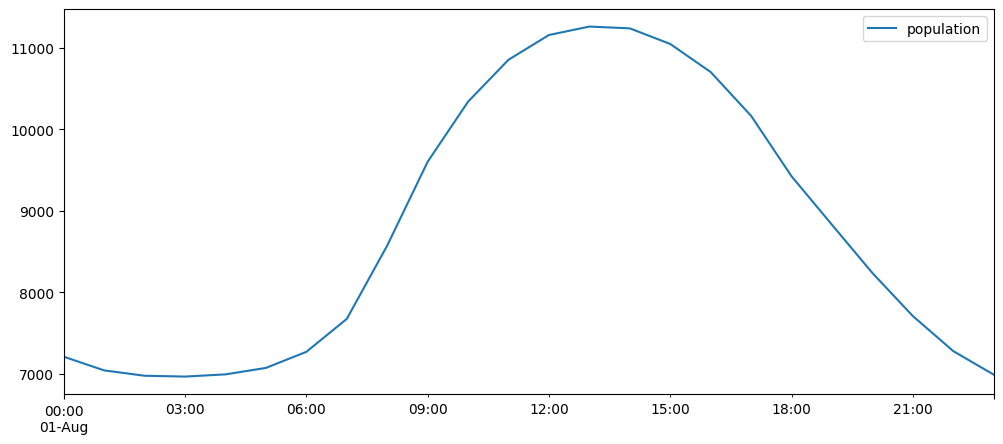

In [35]:
Aug_pred.plot(figsize=(12,5))

In [ ]:
df.to_csv("Aug_pop_prediction.csv", index = True)